In [1]:
import numpy as np
import pymc as pm
from matplotlib import pyplot as plt
from sunode.solver import Solver
import sunode
import sunode.wrappers.as_pytensor
import arviz as az

pm.__version__

'5.10.3'

Test with Lotka - Volterra model.  Copied form 
https://github.com/pymc-devs/sunode

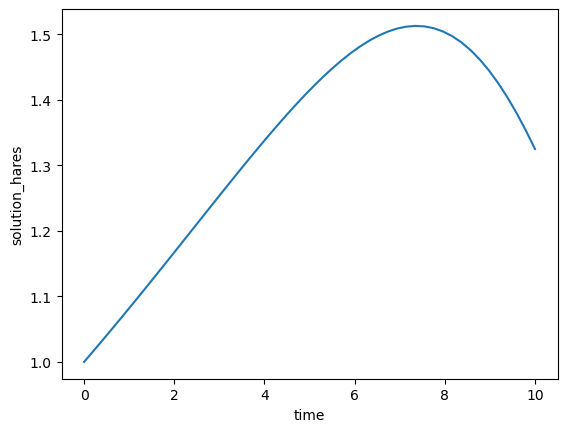

In [2]:
def lotka_volterra(t, y, p):
    """Right hand side of Lotka-Volterra equation.

    All inputs are dataclasses of sympy variables, or in the case
    of non-scalar variables numpy arrays of sympy variables.
    """
    return {
        'hares': p.alpha * y.hares - p.beta * y.lynx * y.hares,
        'lynx': p.delta * y.hares * y.lynx - p.gamma * y.lynx,
    }


from sunode.symode import SympyProblem
problem = SympyProblem(
    params={
        # We need to specify the shape of each parameter.
        # Any empty tuple corresponds to a scalar value.
        'alpha': (),
        'beta': (),
        'gamma': (),
        'delta': (),
    },
    states={
        # The same for all state variables
        'hares': (),
        'lynx': (),
    },
    rhs_sympy=lotka_volterra,
    derivative_params=[
        # We need to specify with respect to which variables
        # gradients should be computed.
        ('alpha',),
        ('beta',),
    ],
)

# The solver generates uses numba and sympy to generate optimized C functions
# for the right-hand-side and if necessary for the jacobian, adoint and
# quadrature functions for gradients.
from sunode.solver import Solver
solver = Solver(problem, sens_mode=None, solver='BDF')


import numpy as np
tvals = np.linspace(0, 10)
# We can use numpy structured arrays as input, so that we don't need
# to think about how the different variables are stored in the array.
# This does not introduce any runtime overhead during solving.
y0 = np.zeros((), dtype=problem.state_dtype)
y0['hares'] = 1
y0['lynx'] = 0.1

# We can also specify the parameters by name:
solver.set_params_dict({
    'alpha': 0.1,
    'beta': 0.2,
    'gamma': 0.3,
    'delta': 0.4,
})

output = solver.make_output_buffers(tvals)
solver.solve(t0=0, tvals=tvals, y0=y0, y_out=output)

# We can convert the solution to an xarray Dataset
solver.as_xarray(tvals, output).solution_hares.plot()


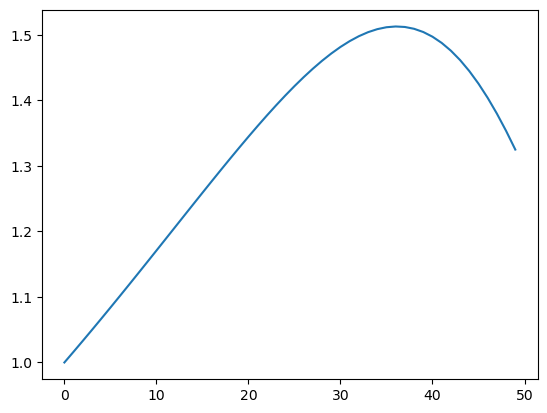

In [3]:

# Or we can convert it to a numpy record array
from matplotlib import pyplot as plt
plt.plot(output.view(problem.state_dtype)['hares'])

Ok now try to use PYMC , again following the same documentation

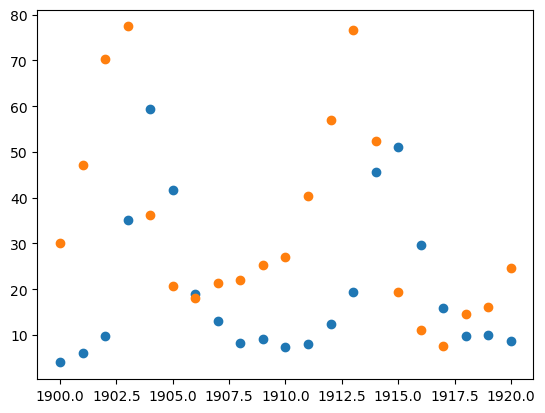

In [4]:
times = np.arange(1900,1921,1)
lynx_data = np.array([
    4.0, 6.1, 9.8, 35.2, 59.4, 41.7, 19.0, 13.0, 8.3, 9.1, 7.4,
    8.0, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6
])
hare_data = np.array([
    30.0, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22.0, 25.4,
    27.1, 40.3, 57.0, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7
])

plt.plot(times, lynx_data, 'o')
plt.plot(times, hare_data, 'o')

In [20]:


with pm.Model() as model_og:
    hares_start = pm.HalfNormal('hares_start', sigma=50)
    lynx_start = pm.HalfNormal('lynx_start', sigma=50)
    
    ratio = pm.Beta('ratio', alpha=0.5, beta=0.5)
        
    fixed_hares = pm.HalfNormal('fixed_hares', sigma=50)
    fixed_lynx = pm.Deterministic('fixed_lynx', ratio * fixed_hares)
    
    period = pm.Gamma('period', mu=10, sigma=1)
    freq = pm.Deterministic('freq', 2 * np.pi / period)
    
    log_speed_ratio = pm.Normal('log_speed_ratio', mu=0, sigma=0.1)
    speed_ratio = np.exp(log_speed_ratio)
    
    # Compute the parameters of the ode based on our prior parameters
    alpha = pm.Deterministic('alpha', freq * speed_ratio * ratio)
    beta = pm.Deterministic('beta', freq * speed_ratio / fixed_hares)
    gamma = pm.Deterministic('gamma', freq / speed_ratio / ratio)
    delta = pm.Deterministic('delta', freq / speed_ratio / fixed_hares / ratio)
    
    y_hat, _, problem, solver, _, _ = sunode.wrappers.as_pytensor.solve_ivp(
        y0={
        # The initial conditions of the ode. Each variable
        # needs to specify a PyTensor or numpy variable and a shape.
        # This dict can be nested.
            'hares': (hares_start, ()),
            'lynx': (lynx_start, ()),
        },
        params={
        # Each parameter of the ode. sunode will only compute derivatives
        # with respect to PyTensor variables. The shape needs to be specified
        # as well. It it infered automatically for numpy variables.
        # This dict can be nested.
            'alpha': (alpha, ()),
            'beta': (beta, ()),
            'gamma': (gamma, ()),
            'delta': (delta, ()),
            'extra': np.zeros(1),
        },
        # A functions that computes the right-hand-side of the ode using
        # sympy variables.
        rhs=lotka_volterra,
        # The time points where we want to access the solution
        tvals=times,
        t0=times[0],
    )
    
    # We can access the individual variables of the solution using the
    # variable names.
    pm.Deterministic('hares_mu', y_hat['hares'])
    pm.Deterministic('lynx_mu', y_hat['lynx'])
    
    sd = pm.HalfNormal('sd')
    pm.LogNormal('hares', mu=y_hat['hares'], sigma=sd, observed=hare_data)
    pm.LogNormal('lynx', mu=y_hat['lynx'], sigma=sd, observed=lynx_data)

Model without reparameterizaition

In [15]:
with pm.Model() as model:
    hares_start = pm.HalfNormal('hares_start', sigma=50)
    lynx_start = pm.HalfNormal('lynx_start', sigma=50)
     
    
     
    alpha = pm.TruncatedNormal('alpha', mu=0.5, sigma = 1, lower = 0, upper=2)
    beta = pm.TruncatedNormal('beta', mu=0.5, sigma = 1, lower = 0, upper=2)
    gamma = pm.TruncatedNormal('gamma', mu=0.5, sigma = 1, lower = 0, upper=2)
    delta = pm.TruncatedNormal('delta', mu=0.5, sigma = 1, lower = 0, upper=2)
    
    y_hat, _, problem, solver, _, _ = sunode.wrappers.as_pytensor.solve_ivp(
        y0={
        # The initial conditions of the ode. Each variable
        # needs to specify a PyTensor or numpy variable and a shape.
        # This dict can be nested.
            'hares': (hares_start, ()),
            'lynx': (lynx_start, ()),
        },
        params={
        # Each parameter of the ode. sunode will only compute derivatives
        # with respect to PyTensor variables. The shape needs to be specified
        # as well. It it infered automatically for numpy variables.
        # This dict can be nested.
            'alpha': (alpha, ()),
            'beta': (beta, ()),
            'gamma': (gamma, ()),
            'delta': (delta, ()),
            'extra': np.zeros(1),
        },
        # A functions that computes the right-hand-side of the ode using
        # sympy variables.
        rhs=lotka_volterra,
        # The time points where we want to access the solution
        tvals=times,
        t0=times[0],
    )
    
    # We can access the individual variables of the solution using the
    # variable names.
    pm.Deterministic('hares_mu', y_hat['hares'])
    pm.Deterministic('lynx_mu', y_hat['lynx'])
    
    sd = pm.Exponential('sd',10)
    pm.Normal('hares', mu=y_hat['hares'], sigma=sd, observed=hare_data)
    pm.Normal('lynx', mu=y_hat['lynx'], sigma=sd, observed=lynx_data)

In [16]:
with model:
    idata = pm.sample(tune=1000, draws=1000, chains =4,cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [hares_start, lynx_start, alpha, beta, gamma, delta, sd]



[CVODES ERROR]  CVode
  At t = 1902.21, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 1902.53, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode

[CVODES ERROR]  CVode
  At t = 1901, mxstep steps taken before reaching tout.

  At t = 1902.31, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 1901.79, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 1900.26, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  

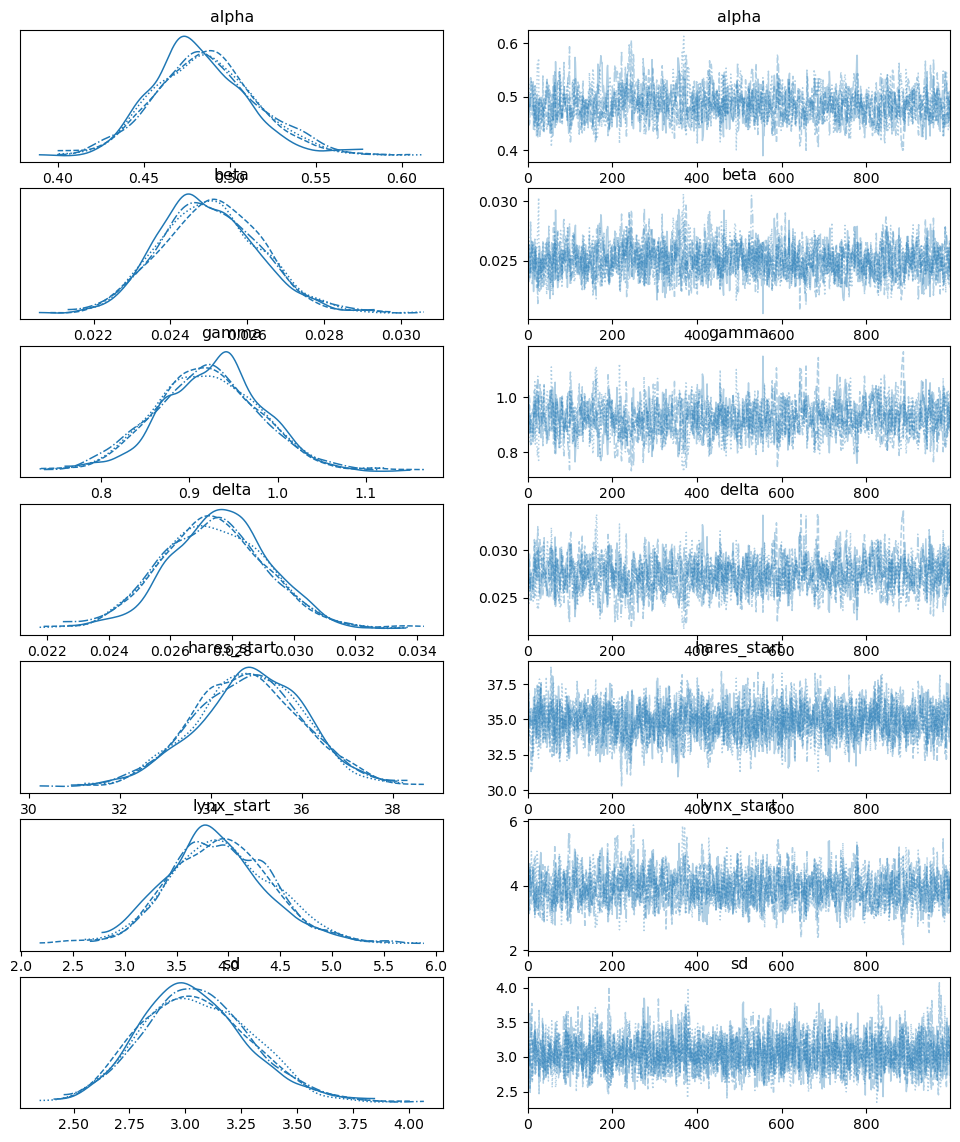

In [17]:
az.plot_trace(idata, var_names=['alpha', 'beta', 'gamma', 'delta', 'hares_start', 'lynx_start', 'sd']);

In [18]:
# list the variables in idata
az.summary(idata, var_names=['alpha', 'beta', 'gamma', 'delta', 'hares_start', 'lynx_start', 'sd'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.485,0.029,0.434,0.544,0.001,0.001,833.0,1081.0,1.00
beta,0.025,0.001,0.023,0.028,0.000,0.000,1046.0,1690.0,1.00
gamma,0.922,0.060,0.806,1.029,0.002,0.001,881.0,1130.0,1.00
delta,0.027,0.002,0.024,0.031,0.000,0.000,945.0,1248.0,1.01
hares_start,34.839,1.190,32.498,36.973,0.031,0.022,1494.0,1817.0,1.00
lynx_start,3.925,0.496,3.059,4.915,0.015,0.011,1148.0,1536.0,1.00
sd,3.048,0.242,2.585,3.477,0.005,0.003,2467.0,2199.0,1.00
